In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-05-23 10:26:16.911312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 10:26:16.911409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 10:26:17.193742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import keras
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

SIZE = 256
high_img = []
low_img = []  # Initialize low_img list
path_high_res = '/kaggle/input/img-superres/AnalyticsArena_DataSet/highres/HighResolution_Train'
files_high_res = os.listdir(path_high_res)
files_high_res = sorted_alphanumeric(files_high_res)
for i in tqdm(files_high_res):
    if i == 'Img3500.jpg':
        break
    else:
      img = Image.open(path_high_res + '/' + i)
    
      # Convert to RGB (if necessary)
      img = img.convert("RGB")
    
      # Resize
      img = img.resize((SIZE, SIZE))
    
      # Convert to numpy array and normalize
      img = np.array(img, dtype=np.float32) / 255.0
    
      high_img.append(img)



100%|██████████| 3500/3500 [00:52<00:00, 67.12it/s]


In [5]:
path_low_res = '/kaggle/input/img-superres/AnalyticsArena_DataSet/lowres/LowReolution_3x_Train'
files_low_res = os.listdir(path_low_res)
files_low_res = sorted_alphanumeric(files_low_res)
for i in tqdm(files_low_res):
    if i == 'Img_down3500.jpg':
        break
    else:
        # Open image
     img = Image.open(path_low_res + '/' + i)
    
     # Convert to RGB (if necessary)
     img = img.convert("RGB")
    
     # Resize
     img = img.resize((SIZE, SIZE))
    
     # Convert to numpy array and normalize
     img = np.array(img, dtype=np.float32) / 255.0
    
     low_img.append(img)

100%|██████████| 3500/3500 [00:33<00:00, 104.82it/s]


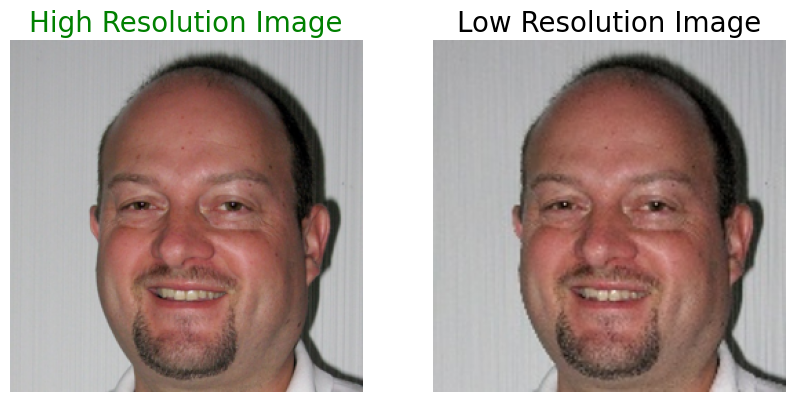

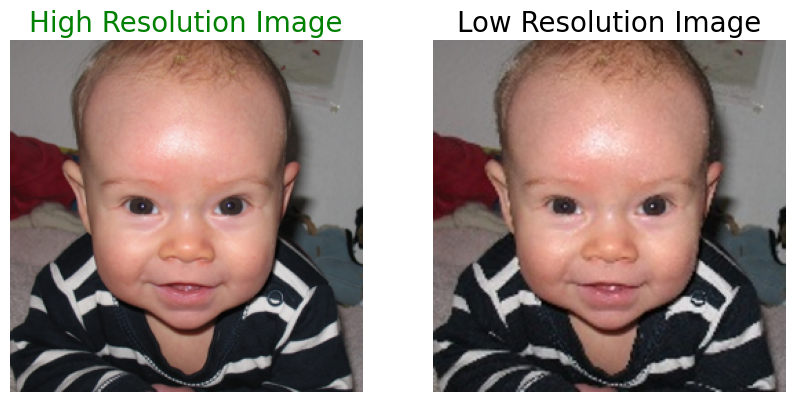

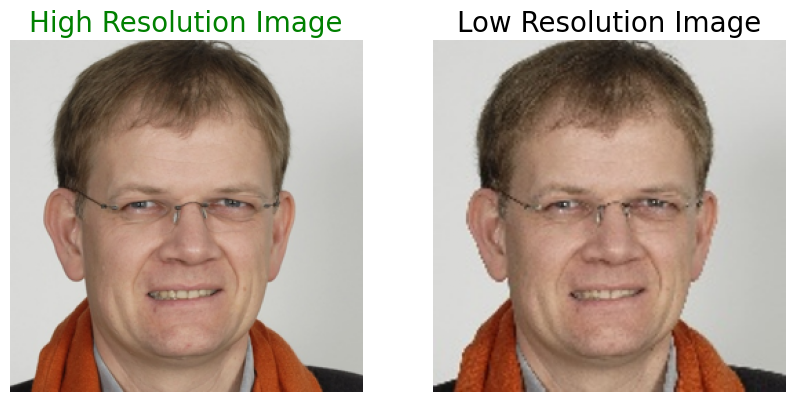

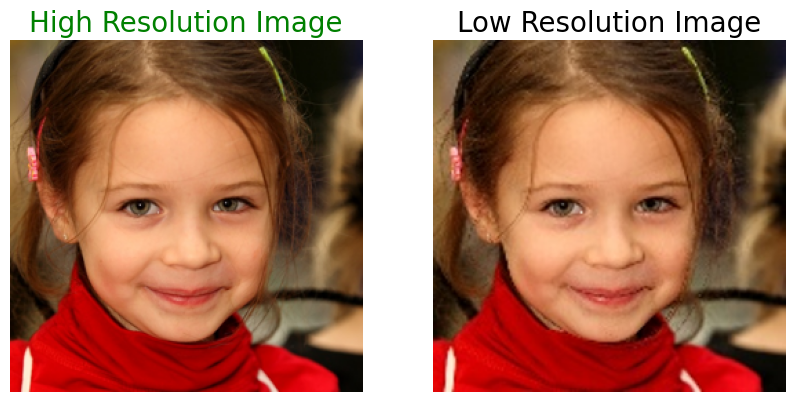

In [5]:
num_samples = 4
random_indices = np.random.choice(len(high_img), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('High Resolution Image', color='green', fontsize=20)
    plt.imshow(high_img[index])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Low Resolution Image', color='black', fontsize=20)
    plt.imshow(low_img[index])
    plt.axis('off')
    plt.show()

In [6]:
train_high_image = high_img[:2000]
train_low_image = low_img[:2000]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[2000:3000]
validation_low_image = low_img[2000:3000]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))

test_high_image = high_img[3000:]
test_low_image = low_img[3000:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (2000, 256, 256, 3)
Shape of test images: (500, 256, 256, 3)
Shape of validation images: (1000, 256, 256, 3)


In [8]:
# Define the SRCNN model
def SRCNN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(128, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the SRCNN model
srcnn_model = SRCNN()

# Compile the model
srcnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
srcnn_model.summary()

# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = srcnn_model.fit(train_low_image, train_high_image,
                          validation_data=(validation_low_image, validation_high_image),
                          epochs=10, batch_size=32, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = srcnn_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, None, None,     │        31,232 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,507 (427.76 KB)

 Trainable params: 109,507 (427.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 493ms/step - loss: 0.1399 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 392ms/step - loss: 0.0055 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - loss: 0.0028 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - loss: 0.0010 - val_loss: 9.1633e-04 - learning_rate: 1.0000e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - loss: 9.5728e-04 - val_loss: 8.5348e-04 - learning_rate: 1.0000e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - loss: 8.7806e-04 - val_loss: 8.0959e-04 - learning_rate: 1.0000e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - loss:

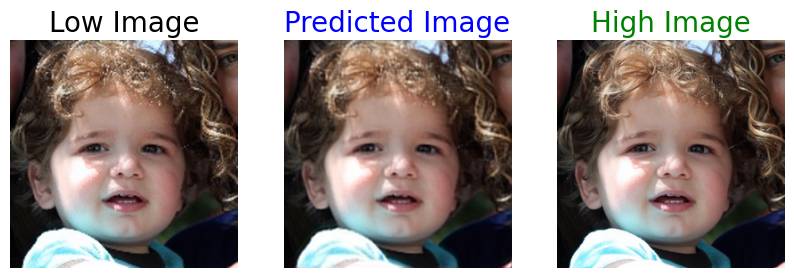

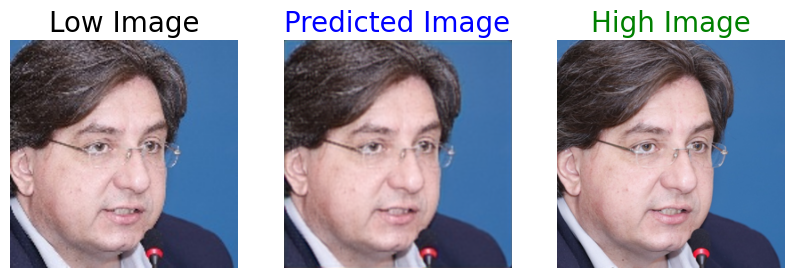

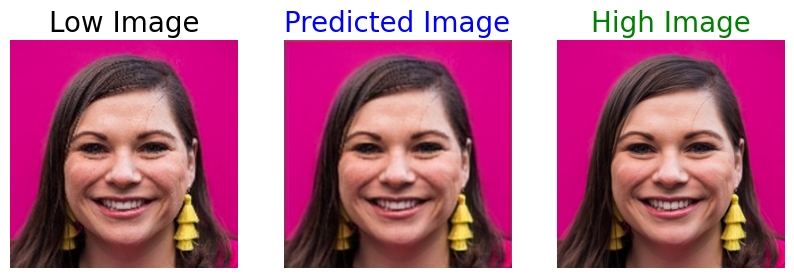

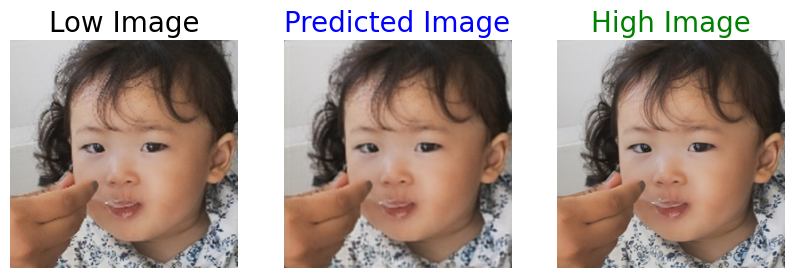

In [9]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [7]:
# Define the FSRCNN model
def FSRCNN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the FSRCNN model
fsrcnn_model = FSRCNN()

# Compile the model
fsrcnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
fsrcnn_model.summary()

# Train the model
history = fsrcnn_model.fit(train_low_image, train_high_image,
                           validation_data=(validation_low_image, validation_high_image),
                           epochs=10, batch_size=32)

# Evaluate the model using PSNR
from skimage.metrics import peak_signal_noise_ratio

def calculate_psnr(original, compressed):
    return peak_signal_noise_ratio(original, compressed)

# Generate predicted high-resolution images for test data
predicted_images = fsrcnn_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, None, None, 64) │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, None, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 32) │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,587 (467.14 KB)

 Trainable params: 119,587 (467.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 550ms/step - loss: 0.0506 - val_loss: 0.0065
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 467ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - loss: 0.0011 - val_loss: 9.2170e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 0.0013 - val_loss: 8.7293e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - loss: 9.2256e-04 - val_loss: 9.4920e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - loss: 9.2799e-04 - val_loss: 8.6343e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - loss: 8.5675e-04 - val_loss: 8.7544e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Average PSNR: 30.92313349145559
Average SSIM: 0.999937550

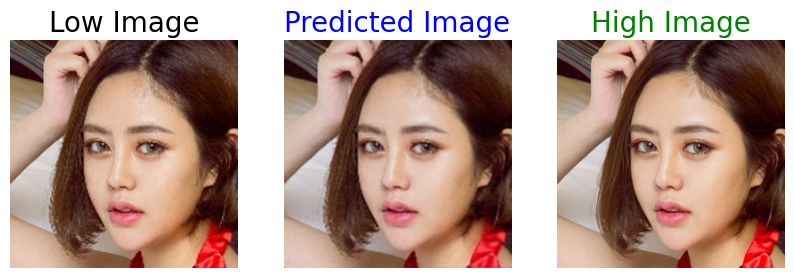

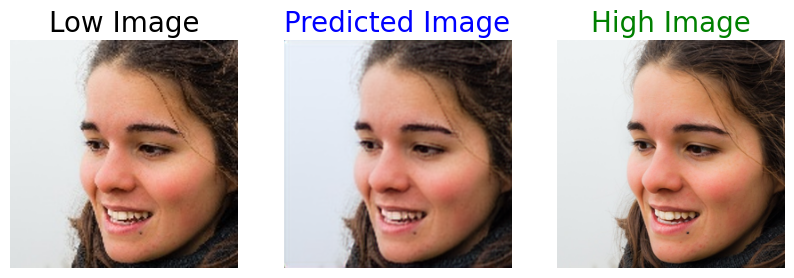

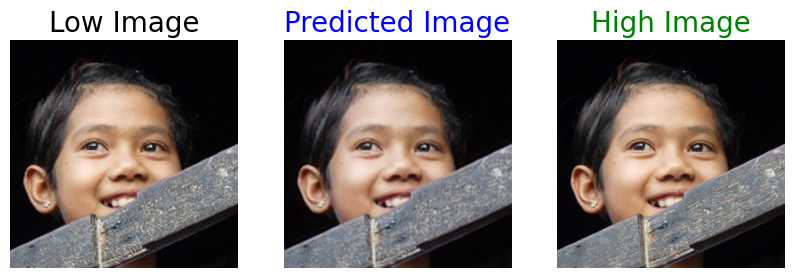

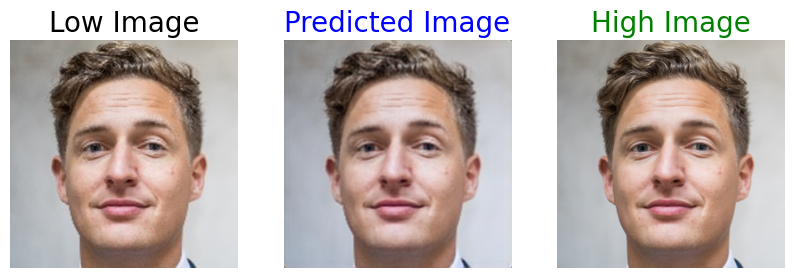

In [8]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [8]:
# Define the VDSR model
def VDSR(input_shape=(None, None, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    for _ in range(18):  # 18 convolutional layers
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)  # Output 3 channels for RGB image
    outputs = layers.Add()([x, inputs])  # Residual learning: F(x) + x
    model = models.Model(inputs, outputs)
    return model

# Instantiate the VDSR model
vdsr_model = VDSR()

# Compile the model
vdsr_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
vdsr_model.summary()

# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = vdsr_model.fit(train_low_image, train_high_image,
                         validation_data=(validation_low_image, validation_high_image),
                         epochs=10, batch_size=1, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = vdsr_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │      1,792 │ input_layer_1[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_20[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_21[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_22[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_23[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_24[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_25[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_26[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_27[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_28[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_29[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_30[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_31[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_32[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_33[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_34[0][0] 

 Total params: 668,227 (2.55 MB)

 Trainable params: 668,227 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 153s 72ms/step - loss: 5.9420e-04 - val_loss: 5.0714e-04 - learning_rate: 1.0000e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - loss: 5.1018e-04 - val_loss: 4.7732e-04 - learning_rate: 1.0000e-04
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - loss: 4.7780e-04 - val_loss: 4.6705e-04 - learning_rate: 1.0000e-04
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.6302e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - loss: 4.6302e-04 - val_loss: 4.6292e-04 - learning_rate: 1.0000e-04
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - loss: 4.5364e-04 - val_loss: 4.4980e-04 - learning_rate: 2.0000e-05
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - loss: 4.5185e-04 - val_loss: 4.4876e-04 - learning_rate: 2.0000e-05
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.5947e-04
Epoch 7: ReduceLROnPlate

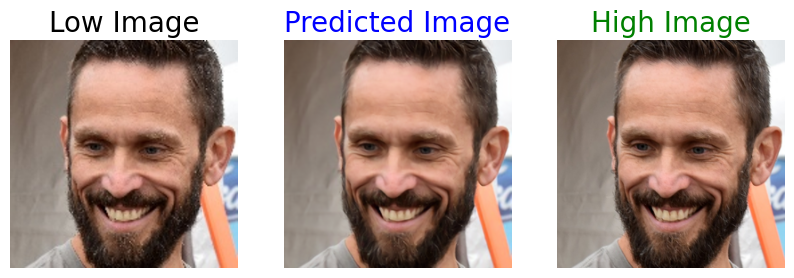

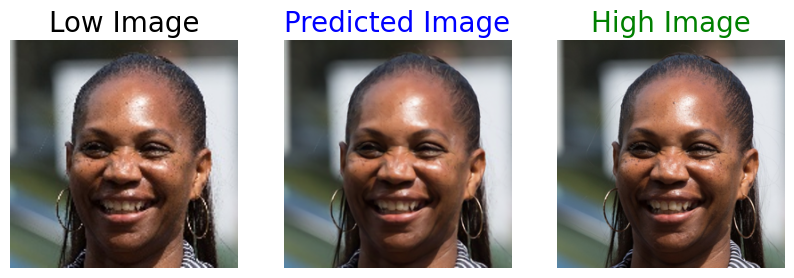

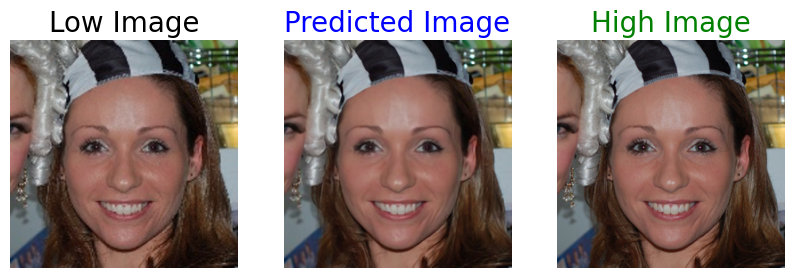

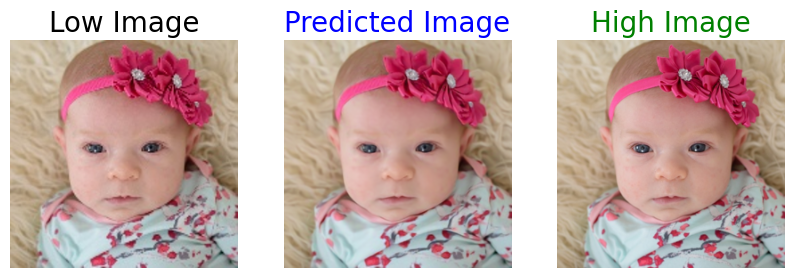

In [9]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [11]:
from tensorflow.keras.layers import Conv2D


class DRCN(tf.keras.Model):
    def __init__(self, num_recursions=16):
        super(DRCN, self).__init__()
        self.input_conv = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.recursive_layer = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.output_conv = Conv2D(3, (3, 3), padding='same')
        self.num_recursions = num_recursions

    def call(self, inputs):
        x = self.input_conv(inputs)
        recursions = [x]
        for _ in range(self.num_recursions):
            x = self.recursive_layer(x)
            recursions.append(x)
        output = tf.reduce_mean(recursions, axis=0)
        output = self.output_conv(output)
        return output

# Instantiate the DRCN model
drcn_model = DRCN()

# Compile the model
drcn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with learning rate reduction on plateau and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = drcn_model.fit(train_low_image, train_high_image,
                         validation_data=(validation_low_image, validation_high_image),
                         epochs=10, batch_size=1, callbacks=[reduce_lr, early_stopping])

# Generate predicted high-resolution images for test data
predicted_images = drcn_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 66ms/step - loss: 0.0205 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 64ms/step - loss: 0.0011 - val_loss: 8.0148e-04 - learning_rate: 1.0000e-04
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 64ms/step - loss: 8.5961e-04 - val_loss: 6.9683e-04 - learning_rate: 1.0000e-04
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 63ms/step - loss: 7.2898e-04 - val_loss: 7.1974e-04 - learning_rate: 1.0000e-04
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 126s 63ms/step - loss: 6.9041e-04 - val_loss: 7.3305e-04 - learning_rate: 1.0000e-04
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 6.9117e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 63ms/step - loss: 6.9116e-04 - val_loss: 6.1140e-04 - learning_rate: 1.0000e-04
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 63ms/step - loss: 6.2041e-04 - val_loss: 6.0972e-04 - learning_

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/93823366.py", line 36, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 513, in predict

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 212, in one_step_on_data_distributed

Out of memory while trying to allocate 11543464192 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   24.15MiB
              constant allocation:         0B
        maybe_live_out allocation:   24.00MiB
     preallocated temp allocation:   10.75GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   10.80GiB
              total fragmentation:   24.00MiB (0.22%)
Peak buffers:
	Buffer 1:
		Size: 2.25GiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_31/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: u8[2416508928]
		==========================

	Buffer 2:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_27/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 3:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_25/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 4:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_23/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 5:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_21/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 6:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_19/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 7:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_17/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 8:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_15/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 9:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_13/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 10:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_11/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 11:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_9/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 12:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_7/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 13:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_5/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 14:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_3/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 15:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="drcn_1_1/conv2d_75_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_167288]

In [ ]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [8]:
# Define the EDSR model
def EDSR(input_shape=(512, 512, 3)):
    model = models.Sequential([
        layers.Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.Add()([x, res])
    return x

def upsample(x, scale):
    assert scale in [2, 3, 4]
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.Lambda(pixel_shuffle(scale))(x)
    return x

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

# Instantiate the EDSR model
edsr_model = EDSR()

# Compile the model
edsr_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
edsr_model.summary()

# Assuming train_low_image, train_high_image, validation_low_image, validation_high_image are numpy arrays with shape (batch_size, 256, 256, 3)
# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = edsr_model.fit(train_low_image, train_high_image,
                         validation_data=(validation_low_image, validation_high_image),
                         epochs=10, batch_size=16)

# Generate predicted high-resolution images for test data
predicted_images = edsr_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 512, 512, 64)   │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 512, 512, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 512, 512, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 512, 512, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,587 (467.14 KB)

 Trainable params: 119,587 (467.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-05-23 10:30:57.176470: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-23 10:30:57.997057: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.820767021s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-23 10:31:00.527947: E external/

  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:26:49 42s/step - loss: 0.2452

I0000 00:00:1716460271.498169      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - loss: 0.0665 - val_loss: 0.0032
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - loss: 0.0011 - val_loss: 9.9710e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - loss: 9.6755e-04 - val_loss: 0.0013
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - loss: 9.7130e-04 - val_loss: 8.5568e-04
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 243ms/step - loss: 8.3563e-04 - val_loss: 7.9669e-04
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - loss: 8.3262e-04 - val_loss: 7.6785e-04
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - loss: 7.8166e-04 - val_loss: 7.5220e-04
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - loss: 8.5826e-04 - val_loss: 7.4532e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step 
Average PSNR: 31.709943896486678

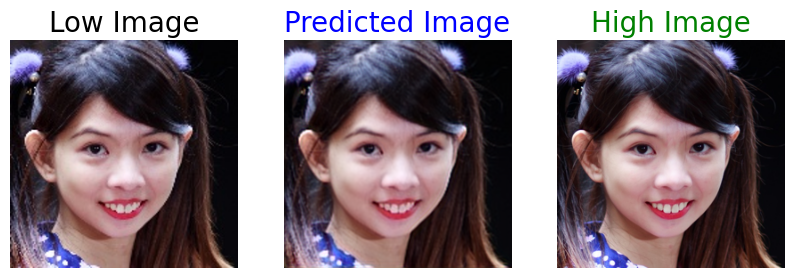

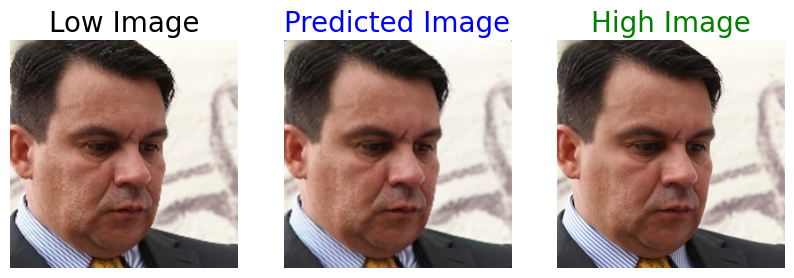

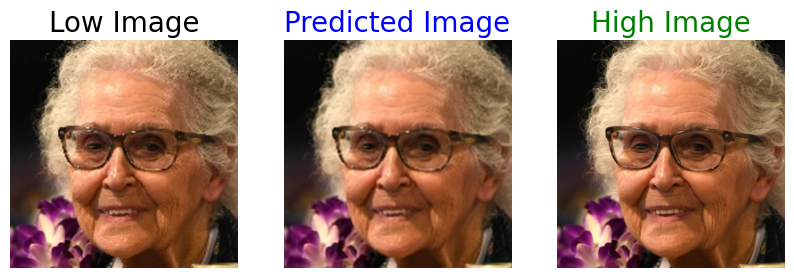

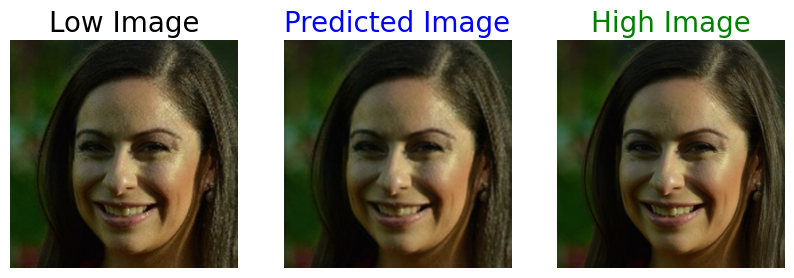

In [9]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [13]:
# Define the RCAN model
def RCAN(input_shape=(None, None, 3), num_res_groups=10, num_res_blocks=20, num_filters=64, reduction=16):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial conv layer
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(inputs)

    # Residual Groups with Channel Attention
    for _ in range(num_res_groups):
        x = residual_group(x, num_res_blocks, num_filters, reduction)
    
    # Conv layer after residual groups
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    
    # Upsampling layer
    x = upsample(x, scale=4)  # assuming a scale factor of 4 for super-resolution
    
    # Output conv layer
    outputs = layers.Conv2D(3, (3, 3), padding='same')(x)
    
    model = models.Model(inputs, outputs)
    return model

def residual_group(x, num_res_blocks, num_filters, reduction):
    res = x
    for _ in range(num_res_blocks):
        x = residual_channel_attention_block(x, num_filters, reduction)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.Add()([x, res])
    return x

def residual_channel_attention_block(x, num_filters, reduction):
    res = x
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = channel_attention(x, num_filters, reduction)
    x = layers.Add()([x, res])
    return x

def channel_attention(x, num_filters, reduction):
    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, num_filters))(avg_pool)
    dense1 = layers.Conv2D(num_filters // reduction, (1, 1), activation='relu', padding='same')(avg_pool)
    dense2 = layers.Conv2D(num_filters, (1, 1), activation='sigmoid', padding='same')(dense1)
    return layers.Multiply()([x, dense2])

def upsample(x, scale):
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    return x

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Instantiate the RCAN model
rcan_model = RCAN()

# Compile the model
rcan_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with learning rate reduction on plateau and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = rcan_model.fit(train_low_image, train_high_image,
                           validation_data=(validation_low_image, validation_high_image),
                           epochs=10, batch_size=32, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = rcan_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


Epoch 1/10


ValueError: Dimensions must be equal, but are 256 and 1024 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, functional_4_1/conv2d_890_1/add)' with input shapes: [?,256,256,3], [?,1024,1024,3].

In [ ]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [10]:
# Define the ESPCN model
def ESPCN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(128, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the ESPCN model
espcn_model = ESPCN()

# Compile the model
espcn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
espcn_model.summary()

# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = espcn_model.fit(train_low_image, train_high_image,
                          validation_data=(validation_low_image, validation_high_image),
                          epochs=10, batch_size=32, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = espcn_model.predict(test_low_image)

# Calculate PSNR and SSIM for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

win_size = 3
data_range = 255
ssim_scores = [structural_similarity(test_high_image[i], predicted_images[i], win_size=win_size, channel_axis=-1, data_range=data_range) for i in range(len(test_high_image))]

# Calculate average PSNR and SSIM across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
average_ssim = sum(ssim_scores) / len(ssim_scores)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, None, None,     │        31,232 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,507 (427.76 KB)

 Trainable params: 109,507 (427.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-05-21 06:07:44.584401: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[32,128,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-21 06:07:46.763737: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.179464566s
Trying algorithm eng0{} for conv (f32[128,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[32,128,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-21 06:07:49.676367: E external/

63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 573ms/step - loss: 0.1198 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - loss: 0.0073 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - loss: 0.0029 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - loss: 0.0013 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - loss: 0.0010 - val_loss: 9.4429e-04 - learning_rate: 1.0000e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - loss: 9.5892e-04 - val_loss: 8.9208e-04 - learning_rate: 1.0000e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - loss: 9.0784e-04 - val_

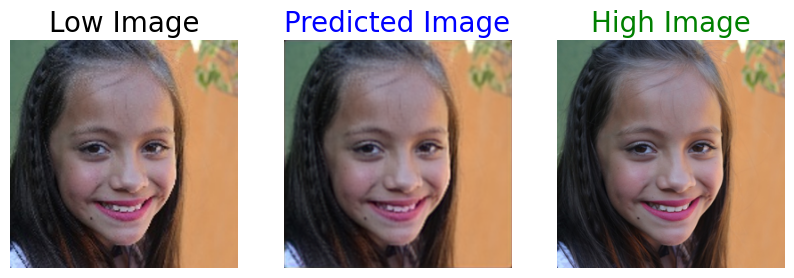

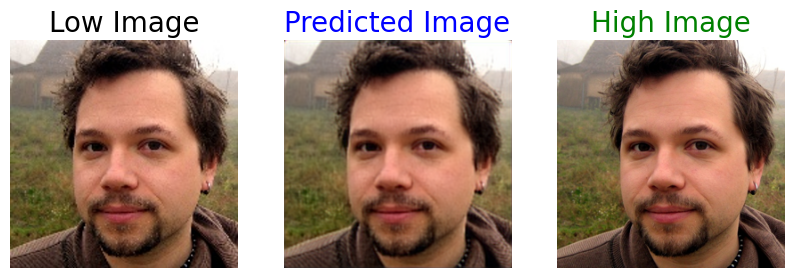

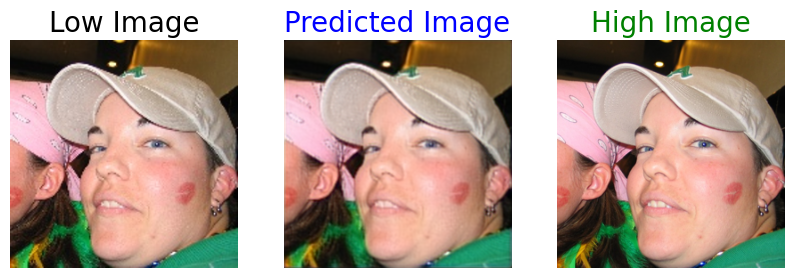

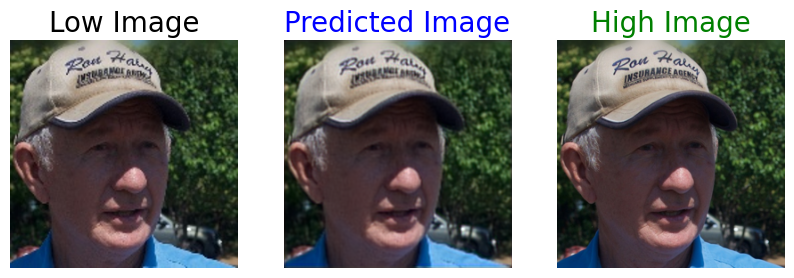

In [11]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()